## Helmholtz en 2D con condiciones de frontera de Dirichlet

En este notebook, resolveremos la ecuación de Helmholtz en 2D con condiciones de frontera de Dirichlet. La ecuación de Helmholtz se utiliza para describir fenómenos de ondas y difusión, abordando variaciones en el tiempo dentro de un dominio espacial o combinado espacio-temporal.

La ecuación de Helmholtz en 2D está dada por:

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + k^2 u = q(x, y), \quad (x, y) \in \Omega $$

donde $ \Omega = [-1, 1] \times [-1, 1] $ y $ k $ es el número de onda.

Las condiciones de frontera son:

$$ u(x, y) = 0, \quad (x, y) \in \partial \Omega $$

El término fuente $ q(x, y) $ está definido como:

$$ q(x, y) = - (a_1 \pi)^2 \sin(a_1 \pi x) \sin(a_2 \pi y) - (a_2 \pi)^2 \sin(a_1 \pi x) \sin(a_2 \pi y) + k^2 \sin(a_1 \pi x) \sin(a_2 \pi y) $$

La solución exacta de la ecuación es:

$$ u(x, y) = \sin(a_1 \pi x) \sin(a_2 \pi y) $$

En este notebook, utilizaremos el método de diferencias finitas para resolver numéricamente esta ecuación y compararemos la solución numérica con la solución exacta.

In [27]:
from devito import Grid, Function,TimeFunction, Eq, Operator, configuration, Eq, solve
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Parameters
nx = 400  # Number of grid points in the x direction
ny = 400  # Number of grid points in the y direction
nt = int(1e4)  # Number of time steps (not used in this static problem)
xmin = -1.  # Minimum x value
ymin = -1.  # Minimum y value
xmax = 1.  # Maximum x value
ymax = 1.  # Maximum y value
extent = (xmin, xmax, ymin, ymax)  # Extent of the grid

# Wave speed parameters
a1 = 2.  # Wave number in the x direction
a2 = 2.  # Wave number in the y direction
k = 1.  # Wave number

# Increase the space order for higher accuracy
space_order = 2

# Create the grid
grid = Grid(shape=(nx, ny), extent=(xmax - xmin, ymax - ymin))
x, y = grid.dimensions
t = grid.stepping_dim

In [29]:
# Create a time-dependent function `p` with the specified grid and space order
p = TimeFunction(name='p', grid=grid, space_order=space_order)

# Initialize the data of `p` to zero
p.data[:] = 0.

In [30]:
# Create the source term `b`
b = Function(name='b', grid=grid, space_order=space_order)

# Generate the x and y values for the grid
x_vals = np.linspace(xmin, xmax, nx)
y_vals = np.linspace(ymin, ymax, ny)

# Create a meshgrid for the x and y values
X, Y = np.meshgrid(x_vals, y_vals)

# Define the source term `b` using the given formula
b.data[:] = (k**2 - (a1 * np.pi)**2 - (a2 * np.pi)**2) * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

In [31]:
# Create the Laplace equation based on `p`
laplace_eq = Eq((-p.laplace + b) / k**2, subdomain=grid.interior)

# Solve the Laplace equation for the central stencil point using SymPy
central_stencil = solve(laplace_eq, p)

# Populate the buffer `p.forward` with the computed stencil
stencil_eq = Eq(p, central_stencil)

# Display the stencil equation
stencil_eq

Eq(p(t, x, y), -0.5*(h_x**2*h_y**2*b(x, y) - h_x**2*p(t, x, y - h_y) - h_x**2*p(t, x, y + h_y) - h_y**2*p(t, x - h_x, y) - h_y**2*p(t, x + h_x, y))/(h_x**2 + h_y**2))

In [32]:
# Create the boundary conditions
# p = 0 at y = ymin
bc = [Eq(p[t + 1, x, 0], 0.)]

# p = 0 at y = ymax
bc += [Eq(p[t + 1, x, ny-1], 0.)]

# p = 0 at x = xmin
bc += [Eq(p[t + 1, 0, y], 0.)]

# p = 0 at x = xmax
bc += [Eq(p[t + 1, nx-1, y], 0.)]

In [33]:
#NBVAL_IGNORE_OUTPUT

# Set the log level to 'ERROR' to reduce verbosity
configuration['log-level'] = 'ERROR'

# Create and execute the operator for a number of timesteps
op = Operator([stencil_eq] + bc)

# Measure the execution time of the operator
%time op(time=nt)

CPU times: user 4.86 s, sys: 0 ns, total: 4.86 s
Wall time: 4.86 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=4.839403000000043, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.010932999999998805, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0007330000000000107, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

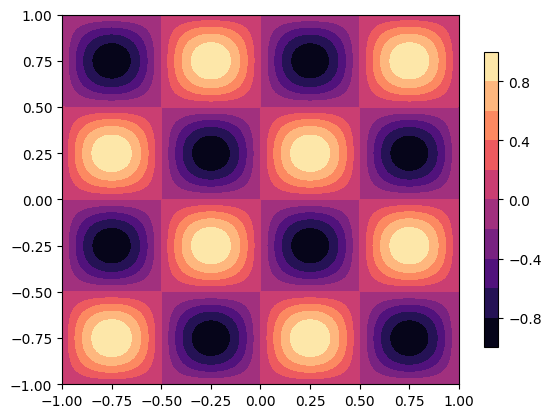

In [34]:
# Plot the numerical solution at the final time step
plt.contourf(p.data[nt], cmap='magma', extent=extent, levels=10)

# Add a colorbar to the plot
plt.colorbar(shrink=0.8)

# Display the plot
plt.show()

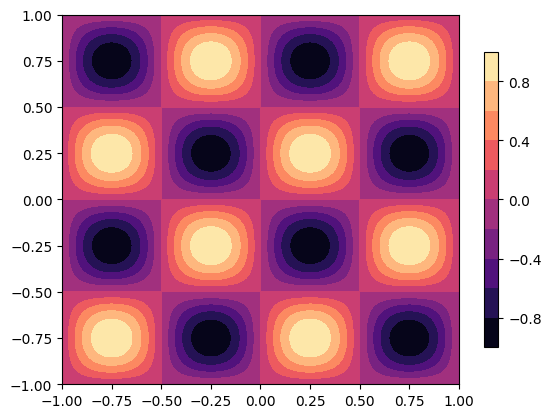

In [37]:
# Calculate the exact solution
u_exact = np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

# Plot the difference between the exact solution and the numerical solution at the final time step
plt.contourf(u_exact, cmap='magma', extent=extent, levels=10)

# Add a colorbar to the plot
plt.colorbar(shrink=0.8)

# Display the plot
plt.show()

In [38]:
# Calculate the relative error
error = np.linalg.norm(p.data[nt].flatten() - u_exact.flatten()) / np.linalg.norm(u_exact.flatten())

# Print the relative error norm
print('Relative error norm: %.5f' % error)

Relative error norm: 0.01826
